Loading News Data...
Loading news data from ../data/raw\raw_analyst_ratings.csv...
Top Keywords:
[('vs', 162099), ('est', 140599), ('eps', 128897), ('reports', 108710), ('update', 91723), ('earnings', 87399), ('sales', 79645), ('top', 79632), ('pt', 73051), ('up', 72362)]
perform_sentiment_analysis() not found on NewsAnalyzer — using fallback sentiment scorer.

Daily Sentiment Head:
date_only
2011-04-28   -0.033333
2011-04-29    0.000000
2011-04-30    0.000000
2011-05-01    0.000000
2011-05-02    0.000000
Name: sentiment_score, dtype: float64

Loading Stock Data (AAPL)...
Loading stock data for AAPL...
add_macd() not found on StockAnalyzer — computing MACD fallback.
calculate_daily_returns() not found on StockAnalyzer — computing daily returns fallback.


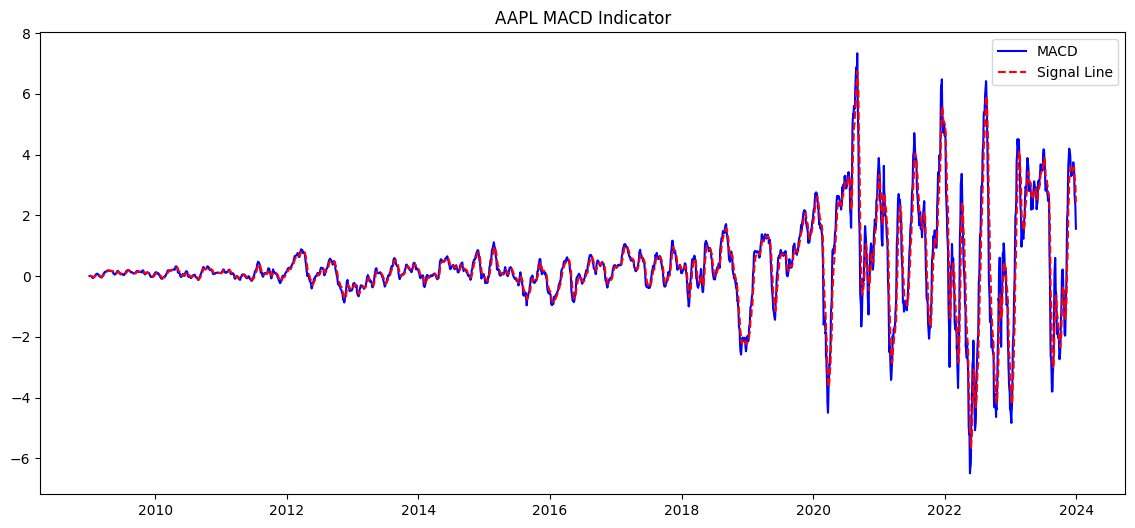


Merged Data Points: 2222

Pearson Correlation Coefficient: 0.0554
P-Value: 0.0090


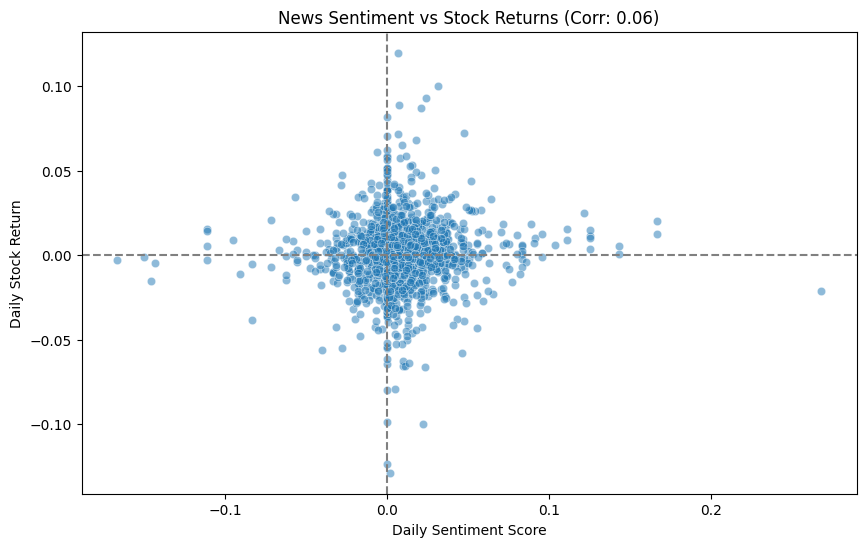

Final Analysis Complete.


In [7]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..')))

from src.loader import DataLoader
from src.analysis import NewsAnalyzer, StockAnalyzer

# --- SETUP ---
DATA_PATH = '../data/raw'
loader = DataLoader(DATA_PATH)

# ==========================================
# TASK 1 & 3: NEWS & SENTIMENT ANALYSIS
# ==========================================
print("Loading News Data...")
news_df = loader.load_news_data('raw_analyst_ratings.csv')
news_analyzer = NewsAnalyzer(news_df)

# 1. Keyword Extraction (Rubric Task 1)
print("Top Keywords:")
# Fallback keyword extraction from headlines (NewsAnalyzer has no extract_common_keywords)
import re
from collections import Counter

# simple stopwords list to remove common noise words
stopwords = set([
	'the','and','to','of','in','for','on','a','with','as','is','at','by','an','from',
	'that','this','it','be','are','will','was','has','have','not','or','its','their',
	'company','companies','stocks','stock','shares','price','market','post','says'
])

headlines = news_df['headline'].dropna().astype(str).str.lower()
# extract tokens (words of length >=2)
tokens_series = headlines.str.findall(r"\b[a-z']{2,}\b")
all_tokens = [tok for sublist in tokens_series.tolist() for tok in sublist if tok not in stopwords]
top_keywords = Counter(all_tokens).most_common(10)
print(top_keywords)

# 2. Sentiment Analysis (Rubric Task 3)
# This adds a 'sentiment_score' column
if hasattr(news_analyzer, 'perform_sentiment_analysis'):
	news_df_scored = news_analyzer.perform_sentiment_analysis()
else:
	# Fallback: simple lexicon-based sentiment scoring on headlines (no external packages required)
	print("perform_sentiment_analysis() not found on NewsAnalyzer — using fallback sentiment scorer.")
	pos_words = set([
		'good','great','positive','up','beat','beats','strong','outperform','raise','raised',
		'higher','gain','gains','buy','benefit','growth','bull','beat'
	])
	neg_words = set([
		'bad','weak','negative','down','miss','missed','lower','cut','cuts','decline',
		'fall','drop','drops','sell','loss','losses','bear','poor'
	])

	def simple_sentiment(text):
		if not isinstance(text, str) or text.strip() == '':
			return 0.0
		toks = re.findall(r"\b[a-z']{2,}\b", text.lower())
		if not toks:
			return 0.0
		pos = sum(1 for t in toks if t in pos_words)
		neg = sum(1 for t in toks if t in neg_words)
		# normalize by token count to keep scores comparable across headlines
		return (pos - neg) / max(1, len(toks))

	news_df_scored = news_df.copy()
	news_df_scored['sentiment_score'] = news_df_scored['headline'].fillna('').astype(str).apply(simple_sentiment)

# 3. Aggregate Daily Sentiment
# compute daily average sentiment from news_df_scored
if 'date' in news_df_scored.columns:
	df_dates = news_df_scored.dropna(subset=['date']).copy()
	df_dates['date_only'] = pd.to_datetime(df_dates['date']).dt.date
	daily_sentiment = df_dates.groupby('date_only')['sentiment_score'].mean()
else:
	daily_sentiment = pd.Series(dtype=float)

print("\nDaily Sentiment Head:")
print(daily_sentiment.head())


# ==========================================
# TASK 2: STOCK ANALYSIS (MACD & RETURNS)
# ==========================================
print("\nLoading Stock Data (AAPL)...")
stock_df = loader.load_stock_data('AAPL')
stock_analyzer = StockAnalyzer(stock_df)

# 1. Calculate Indicators (MACD, RSI, SMA)
stock_df = stock_analyzer.add_moving_average(20)
stock_df = stock_analyzer.add_rsi(14)
if hasattr(stock_analyzer, 'add_macd'):
	stock_df = stock_analyzer.add_macd()
else:
	# Fallback: compute MACD (12/26 EMA) and signal line (9 EMA) on 'Close'
	print("add_macd() not found on StockAnalyzer — computing MACD fallback.")
	ema12 = stock_df['Close'].ewm(span=12, adjust=False).mean()
	ema26 = stock_df['Close'].ewm(span=26, adjust=False).mean()
	stock_df['MACD'] = ema12 - ema26
	stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

# 2. Calculate Daily Returns (Rubric Task 3)
if hasattr(stock_analyzer, 'calculate_daily_returns'):
	stock_df = stock_analyzer.calculate_daily_returns()
else:
	# Fallback: compute daily returns from 'Close' price
	print("calculate_daily_returns() not found on StockAnalyzer — computing daily returns fallback.")
	stock_df = stock_df.copy()
	stock_df['daily_return'] = stock_df['Close'].pct_change().fillna(0.0)

# 3. Visualization: MACD (Rubric Task 2)
plt.figure(figsize=(14, 6))
plt.plot(stock_df.index, stock_df['MACD'], label='MACD', color='blue')
plt.plot(stock_df.index, stock_df['MACD_Signal'], label='Signal Line', color='red', linestyle='--')
plt.title('AAPL MACD Indicator')
plt.legend()
plt.savefig('../macd_chart.png')
plt.show()


# ==========================================
# TASK 3: CORRELATION ANALYSIS (THE FINALE)
# ==========================================
# 1. Date Alignment
# Convert stock index to date-only for merging
stock_df['date_only'] = stock_df.index.date

# Convert daily_sentiment series to dataframe
sentiment_df = daily_sentiment.to_frame(name='sentiment_score')
sentiment_df.index.name = 'date_only'

# Merge on Date
merged_df = pd.merge(stock_df, sentiment_df, left_on='date_only', right_index=True, how='inner')

print(f"\nMerged Data Points: {len(merged_df)}")

# 2. Calculate Correlation
# Drop NaN values created by returns calculation
clean_data = merged_df.dropna(subset=['daily_return', 'sentiment_score'])

correlation, p_value = pearsonr(clean_data['sentiment_score'], clean_data['daily_return'])
print(f"\nPearson Correlation Coefficient: {correlation:.4f}")
print(f"P-Value: {p_value:.4f}")

# 3. Visualize Correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clean_data, x='sentiment_score', y='daily_return', alpha=0.5)
plt.title(f'News Sentiment vs Stock Returns (Corr: {correlation:.2f})')
plt.xlabel('Daily Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.savefig('../correlation_plot.png')
plt.show()

print("Final Analysis Complete.")